# Kaggle Restaurant Competition: Predict Number of visitors
#####  In this competition, we are asked to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates.

by Jonathan Callan

 ###  Working Directory

In [3]:
import os
os.getcwd()

'C:\\Users\\Kalmerrick\\fastai\\python\\kaggle\\Restaurant'

### Imports

In [4]:
# autoreload reloads the modules automatically before entering the execution of the code typed at the Ipython prompt
%load_ext autoreload
%autoreload 2

#matplotlib inline will make your plots output appear and be stored within the notebook
%matplotlib inline

In [5]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn.metrics import mean_squared_error

In [6]:
PATH = 'data/'

In [7]:
os.listdir(PATH)

['air_reserve.csv',
 'air_store_info.csv',
 'air_visit_data.csv',
 'date_info.csv',
 'hpg_reserve.csv',
 'hpg_store_info.csv',
 'models',
 'sample_submission.csv',
 'store_id_relation.csv',
 'submits',
 'test.csv',
 'tmp',
 'train.csv']

## Data import and munging

In [9]:
data = {
    'tra': pd.read_csv(f'{PATH}air_visit_data.csv', low_memory=False),
    'as': pd.read_csv(f'{PATH}air_store_info.csv', low_memory=False),
    'hs': pd.read_csv(f'{PATH}hpg_store_info.csv',low_memory=False),
    'ar': pd.read_csv(f'{PATH}air_reserve.csv',low_memory=False),
    'hr': pd.read_csv(f'{PATH}hpg_reserve.csv',low_memory=False),
    'id': pd.read_csv(f'{PATH}store_id_relation.csv',low_memory=False),
    'tes': pd.read_csv(f'{PATH}sample_submission.csv',low_memory=False),
    'hol': pd.read_csv(f'{PATH}date_info.csv',low_memory=False).rename(columns={'calendar_date':'visit_date'})
    }

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date    
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])

stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])  

train = pd.merge(data['tra'], stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])
    
train = train.fillna(-1)
test = test.fillna(-1)

In [16]:
#train.head()
train.shape
#train.info()

(252108, 19)

In [18]:
#test.head()
test.shape
#test.info() 
# Note Test has an extra column id which will need to be used to enter the Kaggle comp

(32019, 20)

In [19]:
train.to_csv(f'{PATH}train.csv', index= False)

In [20]:
test.to_csv(f'{PATH}test.csv', index = False)

In [21]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory = False,
                    parse_dates = ['visit_date'])

In [22]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory = False,
                     parse_dates = ['visit_date'])

In [23]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [24]:
display_all(df_raw.describe())

,visitors,dow,year,month,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
count,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000,252108.000000
mean,20.973761,3.019678,2016.307697,6.208200,5.305171,20.816460,19.687483,49.308634,50.030304,5.237977,49.794913,35.368196,136.460923,1.496033,0.642074,-0.379587,-0.580588
std,16.757007,1.923985,0.461542,3.680263,6.364927,12.659500,12.784121,37.029759,14.631451,3.155539,30.804083,3.570526,11.707118,155.733715,7.401552,4.747227,2.504373
min,1.000000,0.000000,2016.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.000000,1.000000,2016.000000,3.000000,1.000000,11.016667,10.000000,28.000000,40.000000,2.000000,23.000000,34.688241,135.265455,-1.000000,-1.000000,-1.000000,-1.000000
50%,17.000000,3.000000,2016.000000,7.000000,3.000000,18.256410,17.000000,43.000000,43.000000,6.000000,55.000000,35.658068,139.669361,-1.000000,-1.000000,-1.000000,-1.000000
75%,29.000000,5.000000,2017.000000,10.000000,7.000000,28.058824,27.000000,62.000000,65.000000,7.000000,74.000000,35.694003,139.751599,-1.000000,-1.000000,-1.000000,-1.000000
max,877.000000,6.000000,2017.000000,12.000000,132.000000,147.428571,152.000000,877.000000,69.000000,13.000000,102.000000,44.020632,144.273398,67801.000000,1633.000000,626.000000,157.000000


###  Metric

It is important to note what metric is being used for a project.  In this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted visitors.  Therefore we take the log of the visitors, so that RMSE will give us what we need.

### Functions

In [25]:
def inv_y(a): return np.exp(a)

def RMSLE(y, pred):
    return mean_squared_error(y, pred)**0.5

## Initial processing

This dataset contains a mix of **continuous** and **categorical** variables

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [26]:
add_datepart(df_raw, 'visit_date', drop = False)
add_datepart(df_test, 'visit_date', drop = False)

In [27]:
df_raw.shape
df_test.shape

(32019, 33)

In [29]:
#An example of new created field, in this case visit_Year
df_raw.visit_Year.head()

0    2016
1    2016
2    2016
3    2016
4    2016
Name: visit_Year, dtype: int64

#### Check for missing values

In [30]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

air_area_name              0.0
air_genre_name             0.0
air_store_id               0.0
count_observations         0.0
dow                        0.0
latitude                   0.0
longitude                  0.0
max_visitors               0.0
mean_visitors              0.0
median_visitors            0.0
min_visitors               0.0
month                      0.0
reserve_datetime_diff_x    0.0
reserve_datetime_diff_y    0.0
reserve_visitors_x         0.0
reserve_visitors_y         0.0
visit_Day                  0.0
visit_Dayofweek            0.0
visit_Dayofyear            0.0
visit_Elapsed              0.0
visit_Is_month_end         0.0
visit_Is_month_start       0.0
visit_Is_quarter_end       0.0
visit_Is_quarter_start     0.0
visit_Is_year_end          0.0
visit_Is_year_start        0.0
visit_Month                0.0
visit_Week                 0.0
visit_Year                 0.0
visit_date                 0.0
visitors                   0.0
year                       0.0
dtype: f

Save this file for now, since it's already in format can we be stored and accessed efficiently.

In [32]:
os.makedirs(f'{PATH}tmp', exist_ok=True)
df_raw.to_feather(f'{PATH}tmp/visitors-raw')
df_test.to_feather(f'{PATH}tmp/visitors-test')

### Pre-processing

In the future we can simply read it from this fast format.

In [33]:
df_raw = pd.read_feather(f'{PATH}tmp/visitors-raw')
df_test = pd.read_feather(f'{PATH}tmp/visitors-test')

In [34]:
df_raw.head()
df_raw.shape
#df_raw.info()

(252108, 32)

Replace categories with their numeric codes, handle missing continuous values, and split the dependent variables into a seperate variable.m

In [36]:
joined = df_raw
joined_test = df_test

In [37]:
cat_vars = ['air_store_id','dow', 'year', 'month', 'air_genre_name', 'air_area_name','reserve_datetime_diff_x', 'reserve_visitors_x',
       'reserve_datetime_diff_y', 'reserve_visitors_y','visit_Year',
       'visit_Month', 'visit_Week', 'visit_Day', 'visit_Dayofweek',
       'visit_Dayofyear', 'visit_Is_month_end', 'visit_Is_month_start',
       'visit_Is_quarter_end', 'visit_Is_quarter_start', 'visit_Is_year_end',
       'visit_Is_year_start',]

contin_vars = ['min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations','latitude', 'longitude','visit_Elapsed']

n = len(joined); n

252108

In [40]:
dep = 'visitors'
joined = joined[cat_vars+contin_vars+[dep, 'visit_date']].copy()

In [41]:
joined_test[dep]=0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'visit_date', 'id']].copy()

In [42]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [45]:
joined_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 33 columns):
air_store_id               32019 non-null category
dow                        32019 non-null category
year                       32019 non-null category
month                      32019 non-null category
air_genre_name             32019 non-null category
air_area_name              32019 non-null category
reserve_datetime_diff_x    32015 non-null category
reserve_visitors_x         32018 non-null category
reserve_datetime_diff_y    32019 non-null category
reserve_visitors_y         32019 non-null category
visit_Year                 32019 non-null category
visit_Month                32019 non-null category
visit_Week                 32019 non-null category
visit_Day                  32019 non-null category
visit_Dayofweek            32019 non-null category
visit_Dayofyear            32019 non-null category
visit_Is_month_end         32019 non-null category
visit_Is_month_start    

In [43]:
apply_cats(joined_test, joined)

C:\Users\Kalmerrick\fastai\python\kaggle\Restaurant\fastai\structured.py:200: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [46]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

We're going to run on a sample.

In [47]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("visit_date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

In [48]:
samp_size = n; n
joined_samp = joined.set_index('visit_date')

In [49]:
df, y, nas, mapper = proc_df(joined_samp, 'visitors', do_scale=True)
yl = np.log(y)

In [50]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [51]:
joined_test = joined_test.set_index("visit_date")

In [52]:
df_test, _, nas, mapper = proc_df(joined_test, 'visitors', do_scale=True, skip_flds=['id'],
                                  mapper=mapper, na_dict=nas)

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [53]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [54]:
#val_idx = np.flatnonzero(
   # (df.index<=datetime.datetime(2017,3,12)) & (df.index>=datetime.datetime(2017,4,22)))

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [55]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=64,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [56]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [57]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [58]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.01, 1, [1000,500], [0.01,0.01], y_range=y_range)
lr = 1e-3

In [59]:
m.lr_find()

 57%|██████████████████████████████████████▍                             | 1671/2955 [00:58<00:45, 28.35it/s, loss=1.8]

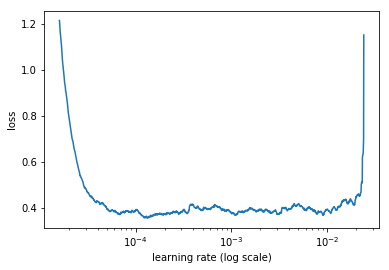

 57%|██████████████████████████████████████▍                             | 1671/2955 [01:10<00:53, 23.87it/s, loss=1.8]

In [60]:
m.sched.plot(100)

### Sample

In [61]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.01, 1, [1000,500], [0.01,0.01], y_range=y_range)
lr = 1e-4

In [62]:
m.fit(lr, 3, metrics=[RMSLE])

  6%|████▏                                                              | 184/2955 [00:06<01:41, 27.22it/s, loss=0.368]
epoch      trn_loss   val_loss   RMSLE                                                                                 
    0      0.346008   0.332528   0.554118  
    1      0.335171   0.331063   0.553853                                                                              
    2      0.315185   0.33035    0.55178                                                                               



[array([0.33035]), 0.5517797667729898]

### All

In [63]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.01, 1, [1000,500], [0.01,0.01], y_range=y_range)
lr = 1e-4

In [64]:
m.fit(lr, 5, metrics=[RMSLE], cycle_len=1)

epoch      trn_loss   val_loss   RMSLE                                                                                 
    0      0.361345   0.33308    0.553961  
    1      0.335016   0.330441   0.552129                                                                              
    2      0.318979   0.330751   0.552441                                                                              
    3      0.320502   0.332023   0.553855                                                                              
    4      0.298657   0.332313   0.554152                                                                              



[array([0.33231]), 0.5541524129734682]

### Test

In [65]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.02, 1, [1000,500], [0.01,0.01], y_range=y_range) 
lr = 1e-2

In [66]:
m.fit(lr, 3, metrics=[RMSLE])

epoch      trn_loss   val_loss   RMSLE                                                                                 
    0      8.246551   7.783886   2.74075   
    1      8.2834     7.783886   2.74075                                                                               
    2      8.418648   7.783886   2.74075                                                                               



[array([7.78389]), 2.7407497154261513]

In [67]:
m.fit(lr, 3, metrics=[RMSLE], cycle_len=1)

epoch      trn_loss   val_loss   RMSLE                                                                                 
    0      8.271889   7.783886   2.74075   
    1      8.319792   7.783886   2.74075                                                                               
    2      8.26797    7.783886   2.74075                                                                               



[array([7.78389]), 2.7407497154261513]

In [68]:
m.save('val0')

In [69]:
m.load('val0')

In [70]:
x,y=m.predict_with_targs()

In [ ]:
#0.57070569632471202
#0.55858214573044118
#0.57656862209140136
#0.57271729959643636

In [71]:
RMSLE(x,y)

2.7899618114742832

In [72]:
pred_test=m.predict(True)

In [73]:
pred_test = np.exp(pred_test)

In [74]:
joined_test['visitors']=pred_test

## Submission

In [75]:
os.makedirs(PATH + 'submits', exist_ok=True)
# Makes the submission name out of folders
path3 = PATH +'submits/'
## labels submissions in order
numFiles=len(os.listdir(path3))
subm_name = 'submission'+str(numFiles)+'.csv'

In [76]:
csv_fn=f'{path3}{subm_name}'

In [77]:
csv_fn

'data/submits/submission8.csv'

In [78]:
joined_test[['id','visitors']].to_csv(csv_fn, index=False)

In [79]:
FileLink(csv_fn)

C:\Users\Kalmerrick\fastai\python\kaggle\Restaurant\data\submits\submission8.csv

## Your Best Entry 
You advanced 53 places on the leaderboard!
Your submission scored 0.501, which is an improvement of your previous score of 0.507. Great job!
Tweet this!

In [80]:
#0.513

In [81]:
#You advanced 175 places on the leaderboard!
#Your submission scored 0.495, which is an improvement of your previous score of 0.501. Great job!

In [82]:
#You advanced 42 places on the leaderboard!
#Your submission scored 0.494, which is an improvement of your previous score of 0.495. Great job!

In [ ]:
# Zero dropout not the best
#Your Best Entry 
#Your submission scored 0.503, which is not an improvement of your best score. Keep trying!